In [100]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [101]:
#Carico il dataset

data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

#data = data.sample(frac=1, random_state=3928).reset_index(drop=True) #shuffle
data = data.sample(frac=1, random_state=234).reset_index(drop=True) #shuffle

print("Shape del dataset : ", data.shape)

Shape del dataset :  (13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


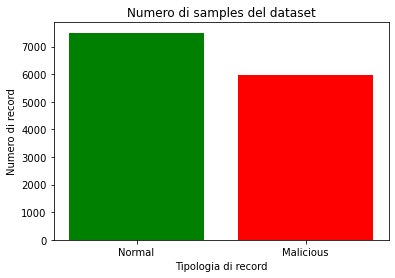

In [102]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

Normal :  7500
R2L :  381
U2R :  50
DOS :  5000
Probe :  520


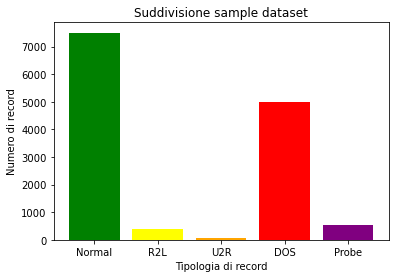

In [103]:
#plot che mi mostra la suddivisione tra i 4 attacchi

r2l_flows_count = len(data[data.result == "r2l"])
u2r_flows_count = len(data[data.result == "u2r"])
dos_flows_count = len(data[data.result == "dos"])
probe_flows_count = len(data[data.result == "probe"])

print("Normal : ",normal_flows_count)
print("R2L : ",r2l_flows_count)
print("U2R : ",u2r_flows_count)
print("DOS : ",dos_flows_count)
print("Probe : ",probe_flows_count)

left = [1, 1.5, 2, 2.5, 3] 
  
# heights of bars 
height = [normal_flows_count, r2l_flows_count, u2r_flows_count, dos_flows_count, probe_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'R2L', "U2R", "DOS", "Probe"] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green','yellow', 'orange', 'red', 'purple']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Suddivisione sample dataset') 
  
plt.show() 

In [104]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

In [105]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
data.flag.replace(flag_list, range(len(flag_list)), inplace=True)

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [106]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Converting count data (index 22, 31, 32) to machine readable...')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Converting type data (index 1, 2, 3) to machine readable...')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Dropping and attaching one-hot encoding data...')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print('Final shape of data:', data_final.shape)

Converting count data (index 22, 31, 32) to machine readable...
Converting type data (index 1, 2, 3) to machine readable...
Dropping and attaching one-hot encoding data...
Final shape of data: (13451, 95)


In [107]:
dos_data = data_final[data_final[94] == "dos"] #prendo solo gli attacchi "dos" 

#60% per il train / 20% per la validation / 20% per il test
data_train, data_val, data_test = np.split(dos_data, [int(.6*len(dos_data)), int(.8*len(dos_data))])

x_train = data_train.drop([94],axis=1) #rimuove la colonna result dal dataframe
x_val = data_val.drop([94], axis=1) #rimuove il label

print("Shape dataframe per il train : ", x_train.shape)
print("Shape dataframe per la validation : ", x_val.shape)

Shape dataframe per il train :  (3000, 94)
Shape dataframe per la validation :  (1000, 94)


In [108]:
x_train_arr = np.asarray(x_train).astype(np.float32)
x_train_arr = x_train_arr.reshape(x_train_arr.shape[0],x_train_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

x_val_arr = np.asarray(x_val).astype(np.float32)
x_val_arr = x_val_arr.reshape(x_val_arr.shape[0],x_val_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM


print("Shape numpy array per il train : ", x_train_arr.shape)
print("Shape numpy array per la validation : ", x_val_arr.shape)

Shape numpy array per il train :  (3000, 94, 1)
Shape numpy array per la validation :  (1000, 94, 1)


In [109]:
model = keras.Sequential(
    [
       layers.Input(shape=(x_train_arr.shape[1],x_train_arr.shape[2])),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(64),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
        
       layers.Dense(128),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(256),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(512),
       layers.Dropout(0.5),
       layers.LeakyReLU(0.01),
       layers.Dense(x_train_arr.shape[1], activation='sigmoid'),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.TimeDistributed(layers.Dense(1)),
    ]
)

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile( optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 94, 16)            1152      
_________________________________________________________________
dense_54 (Dense)             (None, 94, 512)           8704      
_________________________________________________________________
dropout_42 (Dropout)         (None, 94, 512)           0         
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 94, 512)           0         
_________________________________________________________________
dense_55 (Dense)             (None, 94, 256)           131328    
_________________________________________________________________
dropout_43 (Dropout)         (None, 94, 256)           0         
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 94, 256)          

In [110]:
history = model.fit(
    x_train_arr,
    x_train_arr,
    epochs=30,
    batch_size=300,
    validation_data=(x_val_arr, x_val_arr),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
)

Epoch 1/30
10/10 [==============================] - 15s 2s/step - loss: 0.4949 - val_loss: 0.1908
Epoch 2/30
10/10 [==============================] - 15s 1s/step - loss: 0.1597 - val_loss: 0.1777
Epoch 3/30
10/10 [==============================] - 15s 2s/step - loss: 0.1542 - val_loss: 0.1776
Epoch 4/30
10/10 [==============================] - 15s 1s/step - loss: 0.1540 - val_loss: 0.1774
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 0.1535 - val_loss: 0.1752
Epoch 6/30
10/10 [==============================] - 15s 1s/step - loss: 0.1449 - val_loss: 0.1478
Epoch 7/30
10/10 [==============================] - 15s 1s/step - loss: 0.1220 - val_loss: 0.1415
Epoch 8/30
10/10 [==============================] - 16s 2s/step - loss: 0.1159 - val_loss: 0.1367
Epoch 9/30
10/10 [==============================] - 17s 2s/step - loss: 0.1129 - val_loss: 0.1347
Epoch 10/30
10/10 [==============================] - 15s 1s/step - loss: 0.1116 - val_loss: 0.1341
Epoch 11/30
10/10 [

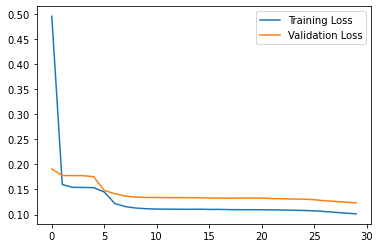

In [111]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

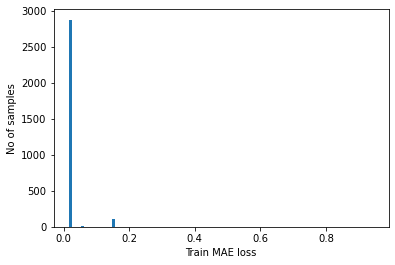

Reconstruction error threshold:  0.018522933


In [112]:
x_train_pred = model.predict(x_train_arr)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_arr), axis=1)
train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
train_mae_loss = np.sort(train_mae_loss) #quicksort


train_mae_loss_len = len(train_mae_loss)
n_index = int(0.75*train_mae_loss_len)
plt.hist(train_mae_loss, bins=100)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
train_mae_loss_split = train_mae_loss[:n_index]
threshold = np.max(train_mae_loss_split)
print("Reconstruction error threshold: ", threshold)

In [113]:
#data_test
#il dataset per il test sarà formato dai 1000 sample dos prelevati precedentemente a cui aggiungerò dei sample normali
#e di altri attacchi (non dos)
#in particolare prelevo il 40% dei sample non dos

not_dos_data = data_final[data_final[94] != "dos"] #prendo solo i valori non "dos"
percentage = 40
not_dos_data = not_dos_data.head(int(len(not_dos_data)*(percentage/100)))
frames = [data_test, not_dos_data]
final_test_data = pd.concat(frames)

print("Shape del dataset per il test: ", final_test_data.shape)

Shape del dataset per il test:  (4380, 95)


Total :  4380
Normal :  2988
Malicious :  1392


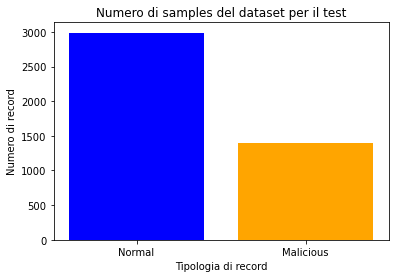

In [114]:
total_flows_count_test = final_test_data[94].count()
normal_flows_count_test = len(final_test_data[final_test_data[94] == "normal"])
anomaly_flows_count_test = len(final_test_data[final_test_data[94] != "normal"])

print("Total : ",total_flows_count_test)
print("Normal : ",normal_flows_count_test)
print("Malicious : ",anomaly_flows_count_test)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count_test, anomaly_flows_count_test] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['blue', 'orange']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset per il test') 
  
plt.show() 



Numero totale di tutte le anomalie : 1392
Numero dei record u2r : 24
Numero dei record r2l : 153
Numero dei record probe : 215
Numero dei record dos : 1000


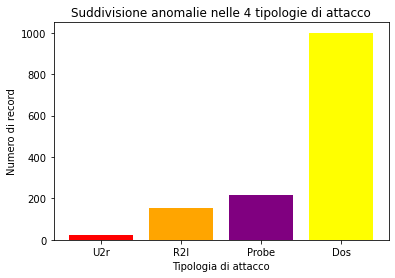

In [115]:
all_anomaly_count = len(final_test_data[final_test_data[94] != "normal"])
u2r_count = len(final_test_data[final_test_data[94] == "u2r"])
r2l_count = len(final_test_data[final_test_data[94] == "r2l"])
probe_count = len(final_test_data[final_test_data[94] == "probe"])
dos_count = len(final_test_data[final_test_data[94] == "dos"])

print('Numero totale di tutte le anomalie :', all_anomaly_count)
print('Numero dei record u2r :', u2r_count)
print('Numero dei record r2l :',r2l_count)
print('Numero dei record probe :',probe_count)
print('Numero dei record dos :',dos_count)

left = [1, 1.5, 2, 2.5] 
  
# heights of bars 
height = [u2r_count, r2l_count, probe_count, dos_count] 
  
# labels for bars 
tick_label = ['U2r', 'R2l', 'Probe', 'Dos'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['red', 'orange', 'purple', 'yellow']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di attacco') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Suddivisione anomalie nelle 4 tipologie di attacco') 
  
plt.show() 


In [116]:
data_test_with_label = final_test_data.copy()
x_test = final_test_data.drop([94],axis=1) #rimuove la colonna dei result dal dataframe

print("x_test shape :", x_test.shape)

x_test shape : (4380, 94)


In [117]:
x_test_arr = np.asarray(x_test).astype(np.float32)
x_test_arr = x_test_arr.reshape(x_test_arr.shape[0],x_test_arr.shape[1],1) #converte la shape da 2d a 3d per layer LSTM

print("Shape numpy array per il test : ", x_test_arr.shape)

Shape numpy array per il test :  (4380, 94, 1)


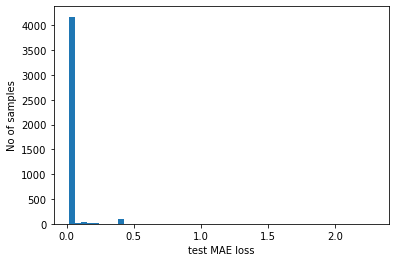

Number di sample normali rilevati:  1497
Numero di sample normali rivelati erroneamente:  434 (FP)
Numero di sample normali rilevati correttamente:  1063 (TP)
Numero di sample normali non rivelati (considerati anomalie):  1925 (FN)
Numero di sample anomali rivelati correttamente 958 (TN)
Numero di sample anomali scambiati per normali 434 (FP)

Numero di sample anomali U2R rilevati correttamente:  5 (TN)
Numero di sample anomali U2R considerati Normali : 19 (FP)
Numero di sample anomali R2L rilevati correttamente:  21 (TN)
Numero di sample anomali R2L considerati normali : 132 (FP)
Numero di sample anomali Probe rilevati correttamente:  190 (TN)
Numero di sample anomali Probe considerati normali : 25 (FP)
Numero di sample anomali Dos rilevati correttamente:  742 (TN)
Numero di sample anomali Dos considerati normali : 258 (FP)

Percentuale di record normali rilevati correttamente sul totale dei record normali -> 35.57563587684069 %
Percentuale di sample anomali rilevati correttamente sul

In [119]:
arr_test_pred = model.predict(x_test_arr)
test_mae_loss = np.mean(np.abs(arr_test_pred - x_test_arr), axis=1)
                                       
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


# Detect all the samples which are anomalies.
not_anomalies = (test_mae_loss > threshold).tolist()
count = 0

u2r_rilevati = 0
u2r_non_rilevati = 0
r2l_rilevati = 0
r2l_non_rilevati = 0
probe_rilevati = 0
probe_non_rilevati = 0
dos_rilevati = 0
dos_non_rilevati = 0
normal_corretti = 0

true_positive = 0
false_negative = 0
false_positive = 0
true_negative = 0

for i in not_anomalies:
    x = str(i)
    if ( x == '[True]'): #record non anomali rilevati
        if ( data_test_with_label.iloc[count][94] == "normal"):
            true_positive = true_positive + 1 #record corretti
        if ( data_test_with_label.iloc[count][94] == "u2r"): #record classificati come normali ma che sono u2r
            u2r_rilevati = u2r_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "r2l"):
            r2l_rilevati = r2l_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "probe"):
            probe_rilevati = probe_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "dos"):
            dos_rilevati = dos_rilevati + 1
    if (x == '[False]'): #record ritenuti anomali dall'autoencoder
        if ( data_test_with_label.iloc[count][94] == "u2r"):
            u2r_non_rilevati = u2r_non_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "r2l"):
            r2l_non_rilevati = r2l_non_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "probe"):
            probe_non_rilevati = probe_non_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "dos"):
            dos_non_rilevati = dos_non_rilevati + 1
        if ( data_test_with_label.iloc[count][94] == "normal"): #record classificati come anomali ma in realtà normali
            false_negative = false_negative + 1
    count = count + 1
    
false_positive = u2r_rilevati + r2l_rilevati + dos_rilevati + probe_rilevati
true_negative = u2r_non_rilevati + r2l_non_rilevati + dos_non_rilevati +  probe_non_rilevati
        
print("Number di sample normali rilevati: ", np.sum(not_anomalies))
print("Numero di sample normali rivelati erroneamente: ", false_positive,'(FP)')
print("Numero di sample normali rilevati correttamente: ", true_positive, '(TP)')
print("Numero di sample normali non rivelati (considerati anomalie): ", false_negative, '(FN)')
print("Numero di sample anomali rivelati correttamente", true_negative,"(TN)")
print("Numero di sample anomali scambiati per normali", false_positive, '(FP)')
print("")
print("Numero di sample anomali U2R rilevati correttamente: ", u2r_non_rilevati, '(TN)')
print("Numero di sample anomali U2R considerati Normali :", u2r_rilevati, '(FP)')
print("Numero di sample anomali R2L rilevati correttamente: ", r2l_non_rilevati, '(TN)')
print("Numero di sample anomali R2L considerati normali :", r2l_rilevati, '(FP)')
print("Numero di sample anomali Probe rilevati correttamente: ", probe_non_rilevati, '(TN)')
print("Numero di sample anomali Probe considerati normali :", probe_rilevati, '(FP)')
print("Numero di sample anomali Dos rilevati correttamente: ", dos_non_rilevati, "(TN)")
print("Numero di sample anomali Dos considerati normali :", dos_rilevati, "(FP)")
print("")
print("Percentuale di record normali rilevati correttamente sul totale dei record normali ->",
      (true_positive/normal_flows_count_test)*100, "%")
print("Percentuale di sample anomali rilevati correttamente sul totale delle anomalie->",
     (true_negative/all_anomaly_count)*100, "%")
#print("Indices of anomaly samples: ", np.where(anomalies))                                       